# Used for simulating chemical reactions

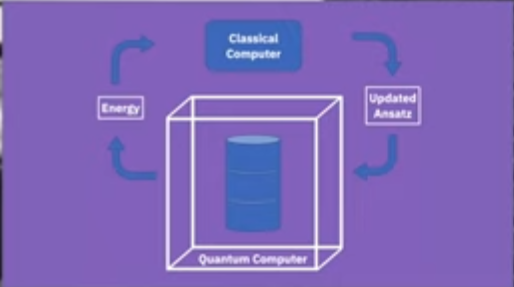

### Code Starts here

In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [2]:
# modeling lithium hidride
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange(0.5,4.25,0.25) # 5 to 4 angstroms in 25 intervals
vqe_energies = [] #array to store energy
hf_energies = []
exact_energies = []

In [3]:
for i,d in enumerate(distances):
    print('step',i)
    
    #set up experiment
    driver = PySCFDriver(molecule.format(d/12), basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                           two_qubit_reduction=True, freeze_core=True, orbital_reduction=[-3,-2])
    qubit_op, aux_ops = operator.run(qmolecule)
    
    #exact classical result
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators = aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)
    
    #VQE
    optimizer = SLSQP(maxiter=1000)
    initial_state=HartreeFock(operator.molecule_info['num_orbitals'], operator.molecule_info['num_particles'], qubit_mapping=operator._qubit_mapping,
                             two_qubit_reduction = operator._two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                    num_particles = operator.molecule_info['num_particles'],
                     initial_state=initial_state,
                    qubit_mapping=operator._qubit_mapping,
                    two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0


/tmp/ipykernel_340/1194904111.py:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,


step 1


/tmp/ipykernel_340/1194904111.py:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,


step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


In [4]:
print(vqe_energies)
print(exact_energies)
print(hf_energies)

[5.759331124482667, -0.08020364763629395, -2.771139398346005, -4.254486910152867, -5.1641654084732345, -5.762370603879732, -6.176619843828057, -6.477048178747302, -6.705767787502496, -6.888571627929462, -7.039732392687986, -7.166852339520416, -7.2747569196289135, -7.366902804685609, -7.445873352185974]
[5.759331035298333, -0.08020371657664782, -2.771139608004537, -4.254486927434373, -5.164165775736645, -5.762370606759734, -6.176619928350654, -6.477048188581803, -6.705767787839531, -6.88857172972231, -7.039732521635203, -7.166852355883883, -7.274756986518577, -7.366902824041548, -7.4458733795014505]
[5.775628214614857, -0.06383452469879813, -2.7547615897722153, -4.238239781273252, -5.148336275779233, -5.747429368201353, -6.163154981963098, -6.465428343279773, -6.695493287967264, -6.878261343411481, -7.02841009454194, -7.15436369161003, -7.261279105252077, -7.3526832459071345, -7.431151163704498]


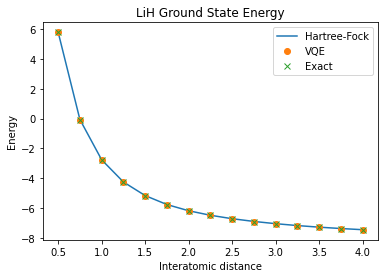

In [5]:
pylab.plot(distances, hf_energies, label= 'Hartree-Fock')
pylab.plot(distances, vqe_energies, 'o', label='VQE')
pylab.plot(distances, exact_energies, 'x', label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title("LiH Ground State Energy")
pylab.legend(loc='upper right')